<h1 align='center'>Fake News Detection</h1>

<h2>Importing Libraries And Datasets</h2>

In [1]:
!pip install tensorflow

  Using cached tensorflow-2.16.1-cp310-cp310-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.1-cp310-cp310-win_amd64.whl.metadata (5.0 kB)
Using cached tensorflow-2.16.1-cp310-cp310-win_amd64.whl (2.1 kB)
Using cached tensorflow_intel-2.16.1-cp310-cp310-win_amd64.whl (376.9 MB)
   ---------------------------------------- 0.0/413.4 kB ? eta -:--:--
   --------------------------------------  409.6/413.4 kB 12.9 MB/s eta 0:00:01
   ---------------------------------------- 413.4/413.4 kB 8.6 MB/s eta 0:00:00


In [2]:
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy
!pip install WordCloud
!pip install gensim

In [293]:
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dudtl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [294]:
# 추가 데이터(크롤링, 생성)
df_true = pd.read_csv("true.csv")
df_fake = pd.read_csv("fake.csv")

<h2>Performing Exploratory Data Analysis</h2>

In [295]:
df_true['isfake'] = 0
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  isfake  
0  December 31, 2017        0  
1  December 29, 2017        0  
2  December 31, 2017        0  
3  December 30, 2017        0  
4  December 29, 2017        0

In [296]:
df_fake['isfake'] = 1
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  isfake  
0  December 31, 2017       1  
1  December 31, 2017       1  
2  December 30, 2017       1  
3  December 29, 2017       1  
4  December 25, 2017       1

In [297]:
# Concatenating Real And Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df = df.dropna(subset=['title'])
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  isfake  
0      December 31, 2017        0  
1      December 29, 2017        0  
2      December 31, 2017        0  
3      December 30, 2017        0  
4      December 29, 2017        0  
...                   ...     ...  
44893    January 16, 2016       1  
44894    January 16, 2016       1  
44895    January 15, 2016       1  
44896    January 14, 2016       1  
44897    January 12, 2016       1  

[44898 rows x 5 columns]

In [298]:
df.drop(columns = ['date'], inplace = True)

In [299]:
# Combining Title And Text Together
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  isfake  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews       0   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews       0   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews       0   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews       0   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews       0   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

In [300]:
df['original'][10000]

'Arizona man challenges primary results, alleging misconduct  PHOENIX (Reuters) - An Arizona man filed a lawsuit on Friday challenging the results of the state’s March presidential primary election, alleging misconduct by officials during a nominating contest that is already mired in controversy. The lawsuit filed by Tucson resident John Brakey alleges that officials improperly handled voter registration requests and permitted illegal votes to be cast in the election, which was marred by long lines at polling stations and allegations of discrimination against minority voters. The three-count complaint, filed late on Friday afternoon against Arizona’s secretary of state and 15 counties, also claims that erroneous ballots were counted by officials on election day. It seeks to enjoin the state from certifying the results “until such election is properly conducted and in compliance with every requirement of Arizona law,” according to the lawsuit. The legal action comes amid an investigatio

<h2>Performing Data Cleaning</h2>

In [301]:
# Downloading Stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dudtl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [302]:
# Obtaining Additional Stopwords From nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

기본 모델 전처리

In [303]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [304]:
# Applying The Function To The Dataframe
df['clean_original'] = df['original'].apply(preprocess)

In [305]:
# Joining The Words Into A String
df['clean_original_joined'] = df['clean_original'].apply(lambda x: " ".join(x))

lemmatization 추가한 전처리

In [306]:
# Removing Stopwords And Remove Words With 2 Or Less Characters
import gensim
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()

def preprocess_lem(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            lemmatized_token = lemma.lemmatize(token)  # 표제어 추출
            result.append(lemmatized_token)
            
    return result

In [307]:
# Applying The Function To The Dataframe
df['clean'] = df['original'].apply(preprocess_lem)

In [308]:
# Joining The Words Into A String
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [309]:
# Showing Original News
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [310]:
# Showing Cleaned Up News After Removing Stopwords
print(df['clean_original'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [311]:
# Showing Cleaned Up News After Removing Stopwords
print(df['clean'][0])

['budget', 'fight', 'loom', 'republican', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cut', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republican', 'representative', 'mark', 'meadow', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmaker', 'bracing', 'battle', 'january', 'return', 'holiday', 'wednesday', 'lawmaker', 'begin', 'trying', 'pas', 'federal', 'budget', 'fight', 'likely', 'linked', 'issue', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaign', 'approach', 'republican', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republican', 'want', 'budget', 'increase', 'military', 'spending', 'democrat', 'want', 'proportional', 'increase', 'defense', 'discretionary', 'spending', 'program', 'support', 'education', 'scientific

In [312]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isfake                                           original  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           0  U.S. military to accept transgender recruits o...   
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           0  FBI Russia probe helped by Australian diplomat...   
4           0  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       1  McPain: John McCain Furious That Iran Treated ...   
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       1  How to Blow $700 Million: Al Jazeera America F...   
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...   

                                          clean_original  \
0      [budget, fight, looms, republicans, flip, fisc...   
1      [military, accept, transgender, recruits, mond...   
2      [senior, republican, senator, mueller, washing...   
3      [russia, probe, helped, australian, diplomat, ...   
4      [trump, wants, postal, service, charge, amazon...   
...                                                  ...   
44893  [mcpain, john, mccain, furious, iran, treated,...   
44894  [justice, yahoo, settles, mail, privacy, class...   
44895  [sunnistan, allied, safe, zone, plan, territor...   
44896  [blow, million, jazeera, america, finally, cal...   
44897  [navy, sailors, held, iranian, military, signs...   

                                   clean_original_joined  \
0      budget fight looms republicans flip fiscal scr...   
1      military accept transgender recruits monday pe...   
2      senior republican senator mueller washington r...   
3      russia probe helped australian diplomat washin...   
4      trump wants postal service charge amazon shipm...   
...                                                  ...   
44893  mcpain john mccain furious iran treated sailor...   
44894  justice yahoo settles mail privacy class actio...   
44895  sunnistan allied safe zone plan territorial bo...   
44896  blow million jazeera america finally calls qui...   
44897  navy sailors held iranian military signs neoco...   

                                                   clean  \
0      [budget, fight, loom, republican, flip, fiscal...   
1      [military, accept, transgender, recruit, monda...   
2 

In [313]:
# Obtaining The Total Words Present In The Dataset
list_of_words_original = []
for i in df.clean_original:
    for j in i:
        list_of_words_original.append(j)

In [314]:
# Obtaining The Total Words Present In The Dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [315]:
len(list_of_words_original)

9276947

In [316]:
len(list_of_words)

9276947

In [317]:
# Obtaining The Total Number Of Unique Words
total_words_original = len(list(set(list_of_words_original)))
total_words_original

108704

In [318]:
# Obtaining The Total Number Of Unique Words
total_words= len(list(set(list_of_words)))
total_words

100980

<h2>Visualizing Cleaned Up Dataset</h2>

<Axes: xlabel='count', ylabel='isfake'>

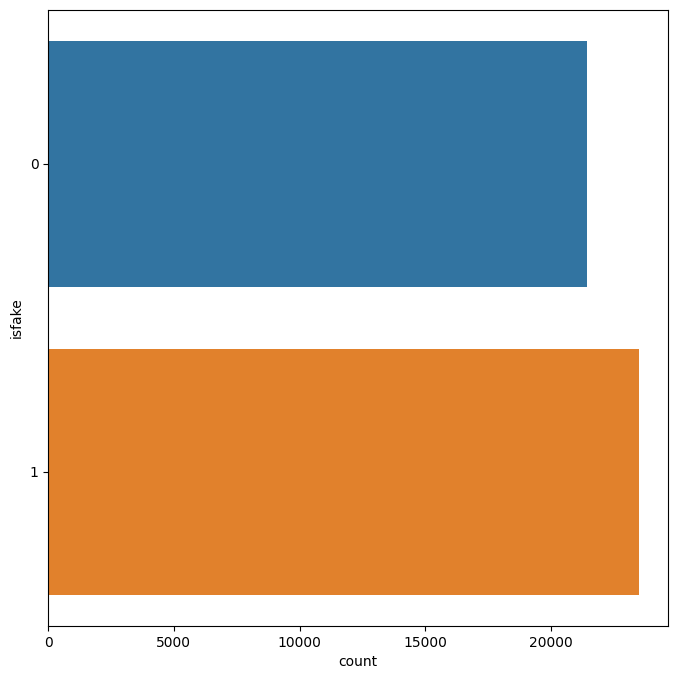

In [319]:
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

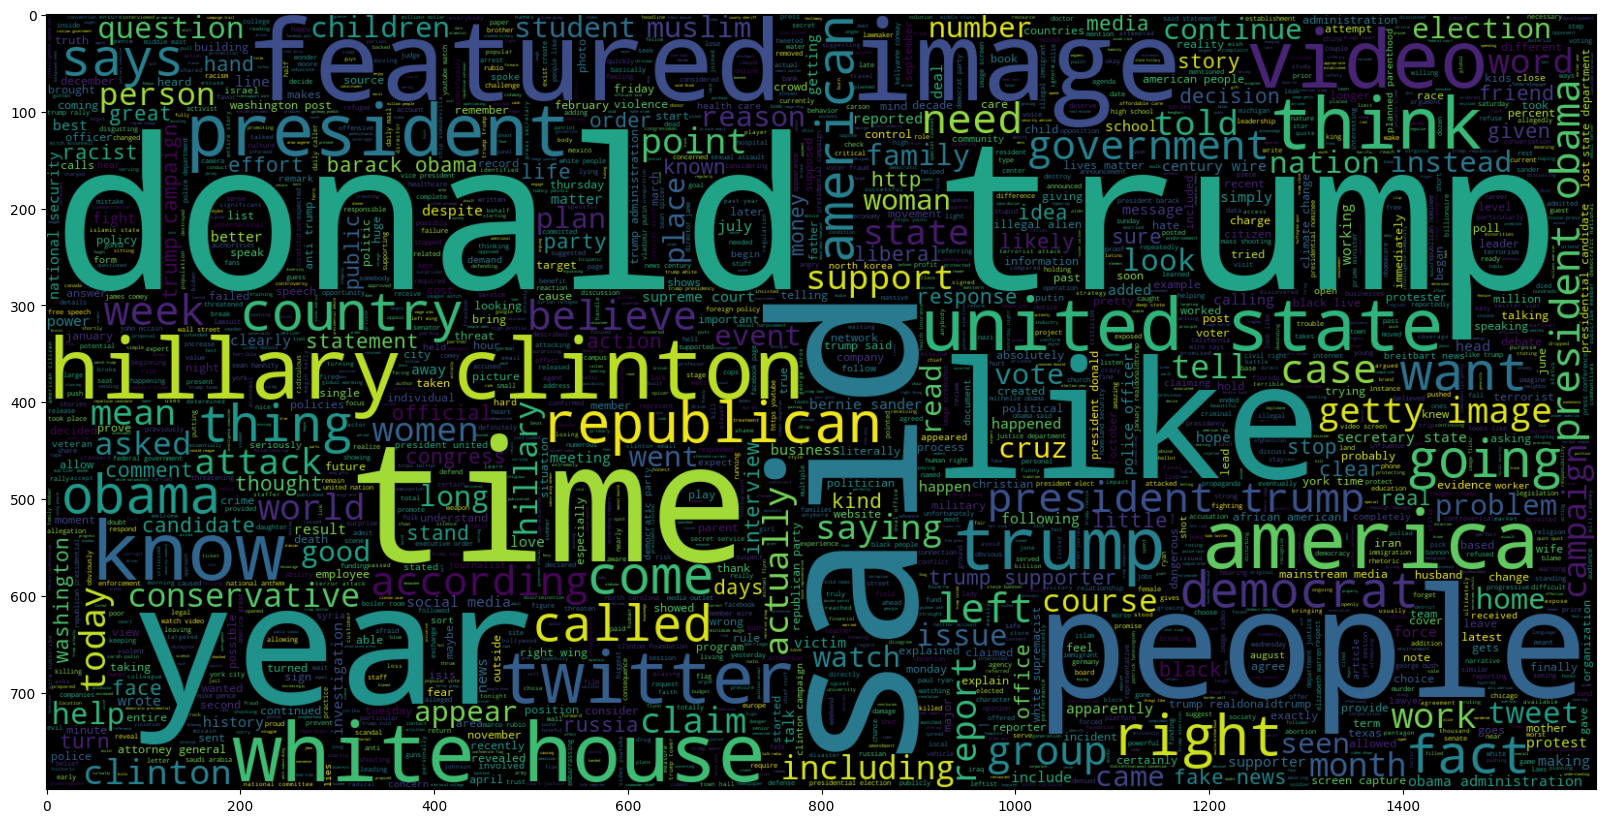

In [320]:
# Plotting The Word Cloud For Text That Is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_original_joined))
plt.imshow(wc, interpolation = 'bilinear')

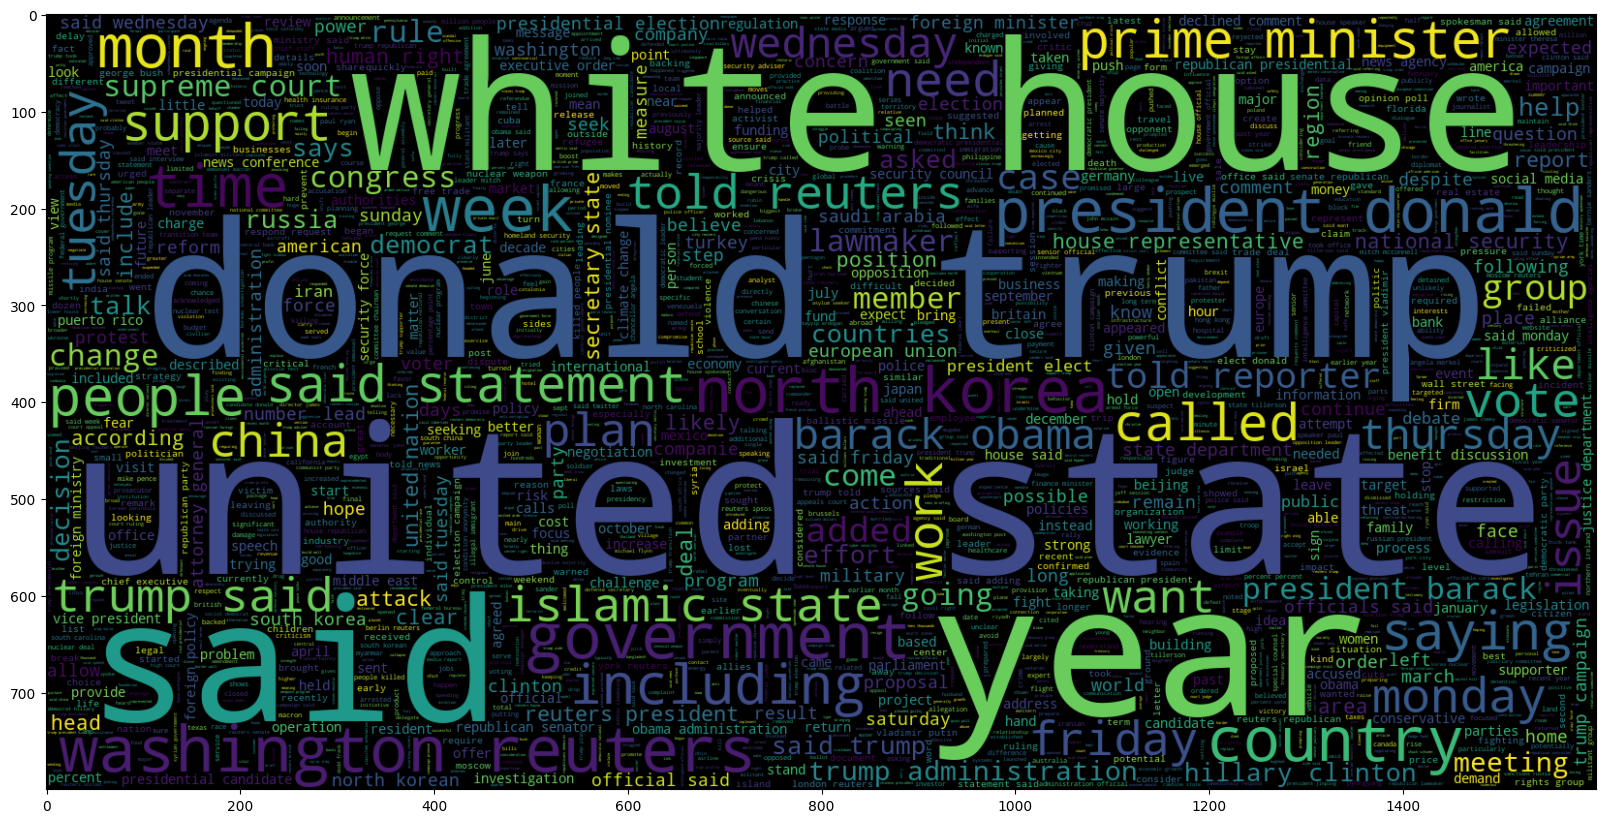

In [321]:
# Plotting The Word Cloud For Text That Is Fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_original_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [322]:
# Determining The Maximum Number Of Words In Any Document Required To Create Word Embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [323]:
# Visualizing The Distribution Of Number Of Words In A Text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

<h2>Preparing The Data By Performing Tokenization And Padding</h2>

기본 모델

In [324]:
# Splitting Data Into Test And Train 
import random
import os
from sklearn.model_selection import train_test_split
from nltk import word_tokenize

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 텍스트 데이터와 라벨 분리
x_train, x_test, y_train, y_test = train_test_split(df.clean_original_joined, df.isfake, test_size = 0.2, random_state=42)

# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
tokenizer = Tokenizer(num_words = total_words_original)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Adding Padding
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

# Sequential Model
model = Sequential()
vector_dim = 100
max_len = 40
# Embeddidng layer
model.add(Embedding(total_words_original, output_dim = vector_dim, input_length=max_len))

# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128, return_sequences=False)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.build(input_shape=(None, max_len))
model.summary()

y_train = np.asarray(y_train)

# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

# Making prediction
pred = model.predict(padded_test)

# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred is the predicted labels
conf_matrix = confusion_matrix(list(y_test), prediction)

# confusion_matrix returns [ [TN, FP], [FN, TP] ]
TN, FP, FN, TP = conf_matrix.ravel()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")

c:\Users\dudtl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_57 (Embedding)        │ (None, 40, 100)        │    10,870,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_54                │ (None, 256)            │       234,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137,921 (42.49 MB)

 Trainable params: 11,137,921 (42.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 137s 254ms/step - acc: 0.9598 - loss: 0.1080 - val_acc: 0.9983 - val_loss: 0.0057
Epoch 2/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 128s 252ms/step - acc: 0.9996 - loss: 0.0017 - val_acc: 0.9983 - val_loss: 0.0043
Epoch 3/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 127s 252ms/step - acc: 1.0000 - loss: 1.3131e-04 - val_acc: 0.9983 - val_loss: 0.0053
Epoch 4/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 129s 253ms/step - acc: 0.9996 - loss: 0.0020 - val_acc: 0.9983 - val_loss: 0.0025
Epoch 5/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 127s 250ms/step - acc: 0.9998 - loss: 3.8180e-04 - val_acc: 0.9986 - val_loss: 0.0033
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Model Accuracy :  0.9957683741648107
True Positives (TP): 4641
False Positives (FP): 29


Functional API로 모델 정의 + Keras의 attention 레이어 사용

In [325]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Attention, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
from sklearn.metrics import classification_report, accuracy_score

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 텍스트 데이터와 라벨 분리
x_train, x_test, y_train, y_test = train_test_split(df.clean_original_joined, df.isfake, test_size = 0.2, random_state=42)

# 토큰화 및 시퀀스 변환
tokenizer = Tokenizer(num_words=20000) # 어휘 사전 크기 설정
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# 시퀀스 패딩
max_sequence_length = 40  # 시퀀스 길이 설정
padded_train = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=max_sequence_length, truncating='post')

vector_dim = 100

# 모델 정의 (Functional API 사용)
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=20000, output_dim=vector_dim, input_length=max_sequence_length)(input_layer)
bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
attention_layer = Attention()([bilstm_layer, bilstm_layer])

# 어텐션 결과를 풀링
average_pooling = GlobalAveragePooling1D()(attention_layer)
max_pooling = GlobalMaxPooling1D()(attention_layer)
concatenated = Concatenate()([average_pooling, max_pooling])

# Dense 레이어
dense_layer = Dense(128, activation='relu')(concatenated)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# 모델 정의
model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# 모델 요약 출력
model.summary()

y_train = np.asarray(y_train)

# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

# Making prediction
pred = model.predict(padded_test)

# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred is the predicted labels
conf_matrix = confusion_matrix(list(y_test), prediction)

# confusion_matrix returns [ [TN, FP], [FN, TP] ]
TN, FP, FN, TP = conf_matrix.ravel()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")


c:\Users\dudtl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_57      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_58        │ (None, 40, 100)   │  2,000,000 │ input_layer_57[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_55    │ (None, 40, 256)   │    234,496 │ embedding_58[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_18        │ (None, 40, 256)   │          0 │ bidirectional_55… │
│ (Attention)         │                   │            │ bidirectional_55… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention_18[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ attention_18[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 512)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_164 (Dense)   │ (None, 128)       │     65,664 │ concatenate_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_165 (Dense)   │ (None, 1)         │        129 │ dense_164[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,300,289 (8.77 MB)

 Trainable params: 2,300,289 (8.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 83s 149ms/step - acc: 0.9608 - loss: 0.1055 - val_acc: 0.9975 - val_loss: 0.0091
Epoch 2/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 71s 140ms/step - acc: 0.9996 - loss: 0.0034 - val_acc: 0.9975 - val_loss: 0.0100
Epoch 3/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 79s 134ms/step - acc: 0.9996 - loss: 0.0039 - val_acc: 0.9983 - val_loss: 0.0095
Epoch 4/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 68s 134ms/step - acc: 0.9998 - loss: 0.0019 - val_acc: 0.9978 - val_loss: 0.0100
Epoch 5/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 68s 134ms/step - acc: 0.9998 - loss: 9.7810e-04 - val_acc: 0.9981 - val_loss: 0.0129
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Model Accuracy :  0.9967706013363029
True Positives (TP): 4641
False Positives (FP): 20


Sequential API로 모델 정의 + 직접 정의한 SelfAttention 클래스 사용

In [326]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Layer, Flatten
from sklearn.metrics import classification_report, accuracy_score

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 텍스트 데이터와 라벨 분리
x_train, x_test, y_train, y_test = train_test_split(df.clean_original_joined, df.isfake, test_size = 0.2, random_state=42)

# 토큰화 및 시퀀스 변환
tokenizer = Tokenizer(num_words=20000) # 어휘 사전 크기 설정
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# 시퀀스 패딩
max_len = 40  # 시퀀스 길이 설정
padded_train = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=max_len, truncating='post')

# Self-Attention 레이어 정의
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.query_dense = Dense(units)
        self.key_dense = Dense(units)
        self.value_dense = Dense(units)
        self.softmax = tf.keras.layers.Softmax(axis=-1)
    
    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        attention_score = tf.matmul(query, key, transpose_b=True)
        attention_weights = self.softmax(attention_score)
        context_vector = tf.matmul(attention_weights, value)
        
        return context_vector

# LSTM 모델 정의
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=100, input_length=max_len))  # 랜덤 초기화된 임베딩
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(SelfAttention(128))
model.add(Flatten())  # 출력 형태를 2D로 만듦
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

y_train = np.asarray(y_train)

# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

# Making prediction
pred = model.predict(padded_test)

# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
        
# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred is the predicted labels
conf_matrix = confusion_matrix(list(y_test), prediction)

# confusion_matrix returns [ [TN, FP], [FN, TP] ]
TN, FP, FN, TP = conf_matrix.ravel()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")

Epoch 1/5


c:\Users\dudtl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



506/506 ━━━━━━━━━━━━━━━━━━━━ 89s 163ms/step - accuracy: 0.9663 - loss: 0.0781 - val_accuracy: 0.9933 - val_loss: 0.0411
Epoch 2/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9969 - val_loss: 0.0200
Epoch 3/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 85s 169ms/step - accuracy: 0.9989 - loss: 0.0140 - val_accuracy: 0.9989 - val_loss: 0.0083
Epoch 4/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 84s 165ms/step - accuracy: 1.0000 - loss: 1.0639e-04 - val_accuracy: 0.9950 - val_loss: 0.0154
Epoch 5/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 83s 165ms/step - accuracy: 0.9999 - loss: 5.4311e-04 - val_accuracy: 0.9981 - val_loss: 0.0149
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
Model Accuracy :  0.9975501113585746
True Positives (TP): 4642
False Positives (FP): 14


Functional API로 모델 정의 + Keras의 attention 레이어 사용 + 전처리

In [327]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Attention, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
from sklearn.metrics import classification_report, accuracy_score

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 텍스트 데이터와 라벨 분리
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size=0.2, random_state=42)

# 토큰화 및 시퀀스 변환
tokenizer = Tokenizer(num_words=20000) # 어휘 사전 크기 설정
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# 시퀀스 패딩
max_sequence_length = 40  # 시퀀스 길이 설정
padded_train = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=max_sequence_length, truncating='post')

# GloVe 벡터 로드 및 임베딩 매트릭스 생성
def load_glove_vectors(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        word_to_vec = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_to_vec[word] = vector
    return word_to_vec

# GloVe 벡터 파일 경로 설정 (다운로드한 GloVe 파일)
glove_file = 'glove.6B.100d.txt'  # 100차원 벡터 파일 예시
word_to_vec = load_glove_vectors(glove_file)
vector_dim = 100

embedding_matrix = np.zeros((20000, vector_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < 20000:
        vector = word_to_vec.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# 모델 정의 (Functional API 사용)
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=20000, output_dim=vector_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)(input_layer)
bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
attention_layer = Attention()([bilstm_layer, bilstm_layer])

# 어텐션 결과를 풀링
average_pooling = GlobalAveragePooling1D()(attention_layer)
max_pooling = GlobalMaxPooling1D()(attention_layer)
concatenated = Concatenate()([average_pooling, max_pooling])

# Dense 레이어
dense_layer = Dense(128, activation='relu')(concatenated)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# 모델 정의
model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# 모델 요약 출력
model.summary()

y_train = np.asarray(y_train)

# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

# Making prediction
pred = model.predict(padded_test)

# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
        
# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred is the predicted labels
conf_matrix = confusion_matrix(list(y_test), prediction)

# confusion_matrix returns [ [TN, FP], [FN, TP] ]
TN, FP, FN, TP = conf_matrix.ravel()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")

c:\Users\dudtl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_59      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_60        │ (None, 40, 100)   │  2,000,000 │ input_layer_59[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_57    │ (None, 40, 256)   │    234,496 │ embedding_60[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_19        │ (None, 40, 256)   │          0 │ bidirectional_57… │
│ (Attention)         │                   │            │ bidirectional_57… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention_19[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ attention_19[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 512)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_171 (Dense)   │ (None, 128)       │     65,664 │ concatenate_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_172 (Dense)   │ (None, 1)         │        129 │ dense_171[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,300,289 (8.77 MB)

 Trainable params: 300,289 (1.15 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 53s 96ms/step - acc: 0.9626 - loss: 0.0972 - val_acc: 0.9978 - val_loss: 0.0111
Epoch 2/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - acc: 0.9984 - loss: 0.0069 - val_acc: 0.9975 - val_loss: 0.0099
Epoch 3/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 49s 96ms/step - acc: 0.9989 - loss: 0.0044 - val_acc: 0.9986 - val_loss: 0.0070
Epoch 4/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - acc: 0.9988 - loss: 0.0048 - val_acc: 0.9981 - val_loss: 0.0060
Epoch 5/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/step - acc: 0.9996 - loss: 0.0018 - val_acc: 0.9978 - val_loss: 0.0117
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Model Accuracy :  0.995879732739421
True Positives (TP): 4622
False Positives (FP): 9


Sequential API로 모델 정의 + 직접 정의한 SelfAttention 클래스 사용 + 전처리

In [328]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Layer, Flatten

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 텍스트 데이터와 라벨 분리
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size=0.2, random_state=42)

# 토큰화 및 시퀀스 변환
tokenizer = Tokenizer(num_words=20000) # 어휘 사전 크기 설정
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# 시퀀스 패딩
max_len = 40  # 시퀀스 길이 설정
padded_train = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=max_len, truncating='post')

# GloVe 벡터 로드 및 임베딩 매트릭스 생성
def load_glove_vectors(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        word_to_vec = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_to_vec[word] = vector
    return word_to_vec

# GloVe 벡터 파일 경로 설정 (다운로드한 GloVe 파일)
glove_file = 'glove.6B.100d.txt'  # 100차원 벡터 파일 예시
word_to_vec = load_glove_vectors(glove_file)
vector_dim = 100

embedding_matrix = np.zeros((20000, vector_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < 20000:
        vector = word_to_vec.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# Self-Attention 레이어 정의
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.query_dense = Dense(units)
        self.key_dense = Dense(units)
        self.value_dense = Dense(units)
        self.softmax = tf.keras.layers.Softmax(axis=-1)
    
    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        attention_score = tf.matmul(query, key, transpose_b=True)
        attention_weights = self.softmax(attention_score)
        context_vector = tf.matmul(attention_weights, value)
        
        return context_vector

# LSTM 모델 정의
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=vector_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(SelfAttention(128))
model.add(Flatten())  # 출력 형태를 2D로 만듦
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

y_train = np.asarray(y_train)

# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

# Making prediction
pred = model.predict(padded_test)

# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
        
# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred is the predicted labels
conf_matrix = confusion_matrix(list(y_test), prediction)

# confusion_matrix returns [ [TN, FP], [FN, TP] ]
TN, FP, FN, TP = conf_matrix.ravel()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")

Epoch 1/5


c:\Users\dudtl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



506/506 ━━━━━━━━━━━━━━━━━━━━ 81s 149ms/step - accuracy: 0.9633 - loss: 0.0835 - val_accuracy: 0.9972 - val_loss: 0.0107
Epoch 2/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 64s 127ms/step - accuracy: 0.9984 - loss: 0.0081 - val_accuracy: 0.9983 - val_loss: 0.0093
Epoch 3/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 62s 122ms/step - accuracy: 0.9986 - loss: 0.0081 - val_accuracy: 0.9964 - val_loss: 0.0181
Epoch 4/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 62s 123ms/step - accuracy: 0.9987 - loss: 0.0056 - val_accuracy: 0.9978 - val_loss: 0.0069
Epoch 5/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 62s 122ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9972 - val_loss: 0.0126
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Model Accuracy :  0.9946547884187082
True Positives (TP): 4613
False Positives (FP): 11
